In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Data preparation

In [48]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("equilibriumm/sleep-efficiency")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sleep-efficiency


In [49]:
# Load dataset
df = pd.read_csv(path + '/Sleep_Efficiency.csv')

In [50]:
#Check for missing values in the records

df.isnull().sum()

,0
ID,0
Age,0
Gender,0
Bedtime,0
Wakeup time,0
Sleep duration,0
Sleep efficiency,0
REM sleep percentage,0
Deep sleep percentage,0
Light sleep percentage,0


In [51]:
# Fill in records with missing values

df["Awakenings"] = df["Awakenings"].fillna(0)
df["Caffeine consumption"] = df["Caffeine consumption"].fillna(0)
df["Alcohol consumption"] = df["Alcohol consumption"].fillna(0)
df["Exercise frequency"] = df["Exercise frequency"].fillna(0)

df.isnull().sum()

,0
ID,0
Age,0
Gender,0
Bedtime,0
Wakeup time,0
Sleep duration,0
Sleep efficiency,0
REM sleep percentage,0
Deep sleep percentage,0
Light sleep percentage,0


In [52]:
# Remove redundant/uninformative variables

df.drop('ID',axis=1,inplace=True)
df.drop('Gender',axis=1,inplace=True)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     452 non-null    int64  
 1   Bedtime                 452 non-null    object 
 2   Wakeup time             452 non-null    object 
 3   Sleep duration          452 non-null    float64
 4   Sleep efficiency        452 non-null    float64
 5   REM sleep percentage    452 non-null    int64  
 6   Deep sleep percentage   452 non-null    int64  
 7   Light sleep percentage  452 non-null    int64  
 8   Awakenings              452 non-null    float64
 9   Caffeine consumption    452 non-null    float64
 10  Alcohol consumption     452 non-null    float64
 11  Smoking status          452 non-null    object 
 12  Exercise frequency      452 non-null    float64
dtypes: float64(6), int64(4), object(3)
memory usage: 46.0+ KB


In [54]:
df.rename(columns={'Wakeup time': 'Wakeup_time'}, inplace=True)
df['Bedtime'] = pd.to_datetime(df['Bedtime'])
df['Wakeup_time']  = pd.to_datetime(df['Wakeup_time'])

In [55]:
# get rid of the day, year and month, remain the hour only
df['Bedtime'] = df.Bedtime.apply(lambda x: x.hour)
df['Wakeup_time'] = df.Wakeup_time.apply(lambda x: x.hour)

In [56]:
display(df.head())

,Age,Bedtime,Wakeup_time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,65,1,7,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,69,2,9,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,40,21,5,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,40,2,8,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,57,1,9,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


In [57]:
#smaller values mean waking up earlier
#bigger values mean waking up later
df['Wakeup_time'].unique()

array([ 7,  9,  5,  8,  4,  3, 10,  6, 11, 12])

In [58]:
#categorizing bedtime: smaller values mean sleeping early while higher values mean sleeping later
df.loc[df['Bedtime'] == 21, 'Bedtime'] = 10
df.loc[df['Bedtime'] ==22 , 'Bedtime'] = 20
df.loc[df['Bedtime'] ==23   , 'Bedtime']  = 30
df.loc[df['Bedtime'] ==0 , 'Bedtime'] = 40
df.loc[df['Bedtime'] ==1 , 'Bedtime'] = 50
df.loc[df['Bedtime'] ==2 , 'Bedtime'] = 60

In [59]:
# Copy and prepare the dataset
df_cleaned = df.copy()

# Define categorical and numeric columns
categorical_features = ['Smoking status']
numeric_features = df_cleaned.drop(columns=categorical_features).columns.tolist()

# Create column transformer: scale numerics, encode categoricals
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Apply the transformation
X_processed = preprocessor.fit_transform(df_cleaned)

# Get feature names
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
processed_feature_names = numeric_features + list(encoded_feature_names)

X_processed_df = pd.DataFrame(X_processed, columns=processed_feature_names)

# DIY clustering

In [75]:
def initialize_centroids_kmeans_pp(X, k, random_state=None):
    np.random.seed(random_state)
    n_samples, _ = X.shape

    # Choose one center randomly
    centroids = [X[np.random.randint(n_samples)]]

    for _ in range(1, k):
        # Compute squared distances to the nearest centroid
        distances = np.array([
            min(np.sum((x - c) ** 2) for c in centroids)
            for x in X
        ])

        # Select next centroid with weighted probability
        probs = distances / distances.sum()
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()

        for j, p in enumerate(cumulative_probs):
            if r < p:
                centroids.append(X[j])
                break

    return np.array(centroids)

In [80]:
class KMeansDIY:
    def __init__(self, k=3, max_iters=100, tol=1e-4, random_state=42):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None

    def _initialize_centroids(self, X):
        return initialize_centroids_kmeans_pp(X, self.k, random_state=self.random_state)

    def _assign_clusters(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.k)])
        return new_centroids

    def fit(self, X):
        X = np.array(X)
        self.centroids = self._initialize_centroids(X)

        for i in range(self.max_iters):
            labels = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, labels)

            # Convergence check
            if np.all(np.linalg.norm(self.centroids - new_centroids, axis=1) < self.tol):
                break

            self.centroids = new_centroids

        self.labels_ = self._assign_clusters(X)

    def predict(self, X):
        X = np.array(X)
        return self._assign_clusters(X)


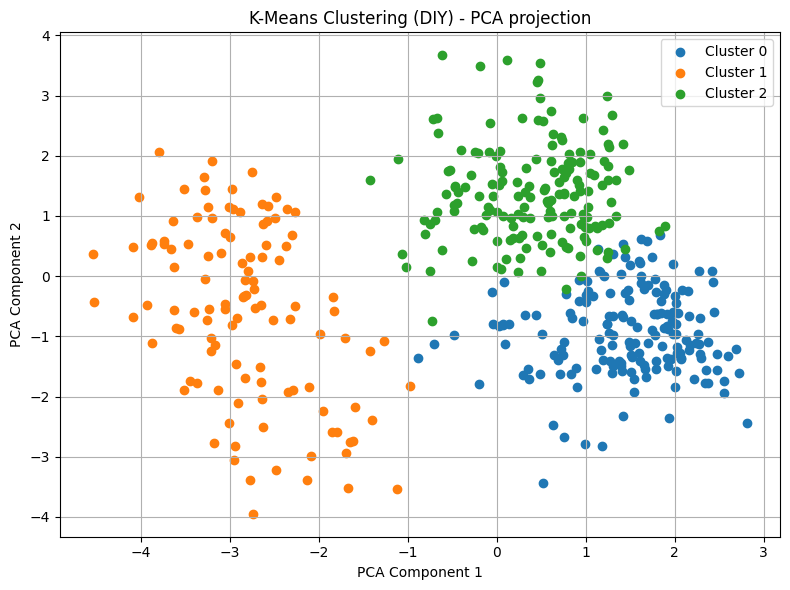

In [81]:
# Run the model and visualize
X = X_processed_df.values
kmeans_DIY = KMeansDIY(k=3)
kmeans_DIY.fit(X)

# PCA for 2D plotting
X_clustered = X_processed_df.copy()
X_clustered['Cluster'] = kmeans_DIY.labels_
X_pca = PCA(n_components=2).fit_transform(X)
X_clustered['PCA1'] = X_pca[:, 0]
X_clustered['PCA2'] = X_pca[:, 1]

# Plotting
plt.figure(figsize=(8, 6))
for cluster in range(3):
    cluster_data = X_clustered[X_clustered['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')
plt.title("K-Means Clustering (DIY) - PCA projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


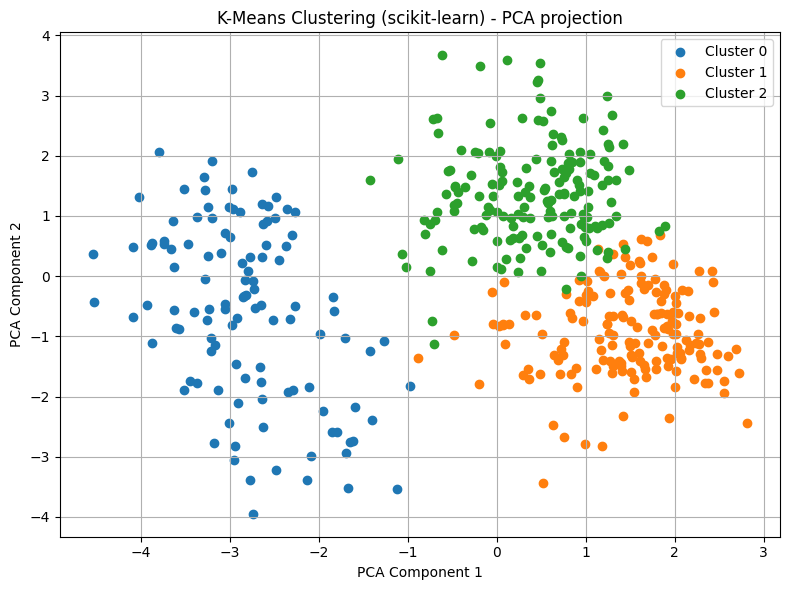

In [82]:
# Fit sklearn's KMeans
kmeans_sklearn = KMeans(n_clusters=3, random_state=42)
kmeans_sklearn.fit(X)

# Get labels
labels_sklearn = kmeans_sklearn.labels_

# Add sklearn labels and PCA coordinates for comparison
X_clustered['Cluster_sklearn'] = labels_sklearn

plt.figure(figsize=(8, 6))
for cluster in range(3):
    cluster_data = X_clustered[X_clustered['Cluster_sklearn'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')
plt.title("K-Means Clustering (scikit-learn) - PCA projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
# Comparison

# Compute silhouette scores for both models
silhouette_DIY = silhouette_score(X, kmeans_DIY.labels_)
silhouette_sklearn = silhouette_score(X, labels_sklearn)

# Return silhouette scores for both
print(f"DIY clustering silhouette score: {silhouette_DIY}")
print(f"Sklearn clustering silhouette score: {silhouette_sklearn}")

DIY clustering silhouette score: 0.1850605199037443
Sklearn clustering silhouette score: 0.1851214026802251


Conclusion: by silhouette score DIY Clustering and Sklearn Clustering works very similarly with 3 clusters.

In [84]:
def compute_inertia(X, labels, centroids):
    inertia = 0.0
    for i in range(centroids.shape[0]):
        cluster_points = X[labels == i]
        inertia += np.sum((cluster_points - centroids[i])**2)
    return inertia

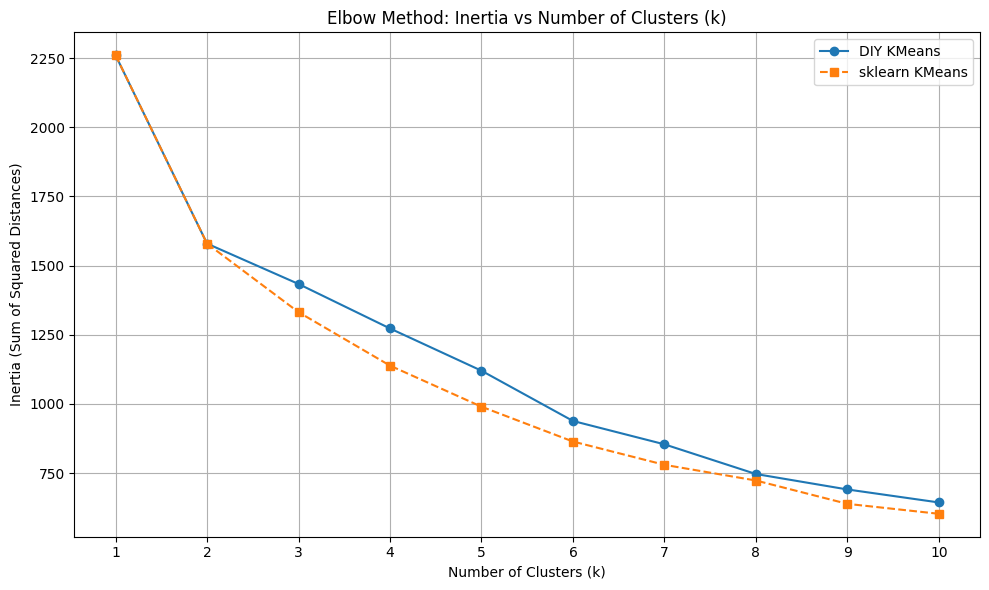

In [86]:
features = ['Sleep duration', 'Bedtime', 'Wakeup_time', 'Caffeine consumption', 'Alcohol consumption']
X = df[features].values

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ks = range(1, 11)
inertias_diy = []
inertias_sklearn = []

for k in ks:
    # DIY KMeans
    model_diy = KMeansDIY(k=k, max_iters=100, random_state=42)
    model_diy.fit(X_scaled)
    inertia_diy = compute_inertia(X_scaled, model_diy.labels_, model_diy.centroids)
    inertias_diy.append(inertia_diy)

    # scikit-learn KMeans
    model_sklearn = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    model_sklearn.fit(X_scaled)
    inertias_sklearn.append(model_sklearn.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(ks, inertias_diy, 'o-', label='DIY KMeans')
plt.plot(ks, inertias_sklearn, 's--', label='sklearn KMeans')
plt.title('Elbow Method: Inertia vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(ks)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Clustering (k-means and DBSCAN from scikit-learn)

In [87]:
# Feature sets

features_A = ['Sleep duration', 'Bedtime', 'Wakeup_time', 'Caffeine consumption', 'Alcohol consumption']
X_A = df[features_A].values
X_A_scaled = StandardScaler().fit_transform(X_A)

smoking_encoded = pd.get_dummies(df['Smoking status'], prefix='Smoking', drop_first=True)
features_B = ['Sleep duration', 'Awakenings', 'Exercise frequency']
X_B = pd.concat([df[features_B], smoking_encoded], axis=1).values
X_B_scaled = StandardScaler().fit_transform(X_B)

In [102]:
# KMeans on A
kmeans_A = KMeans(n_clusters=3, init='k-means++', random_state=42)
labels_kmeans_A = kmeans_A.fit_predict(X_A_scaled)

# KMeans on B
kmeans_B = KMeans(n_clusters=3, init='k-means++', random_state=42)
labels_kmeans_B = kmeans_B.fit_predict(X_B_scaled)

# DBSCAN on A
dbscan_A = DBSCAN(eps=1.2, min_samples=5)  # eps may need tuning
labels_dbscan_A = dbscan_A.fit_predict(X_A_scaled)

# DBSCAN on B
dbscan_B = DBSCAN(eps=1.2, min_samples=5)  # eps may need tuning
labels_dbscan_B = dbscan_B.fit_predict(X_B_scaled)

In [92]:
# PCA Visualization Function
def plot_pca(X_scaled, labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=15)
    plt.title(f'PCA - {title}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

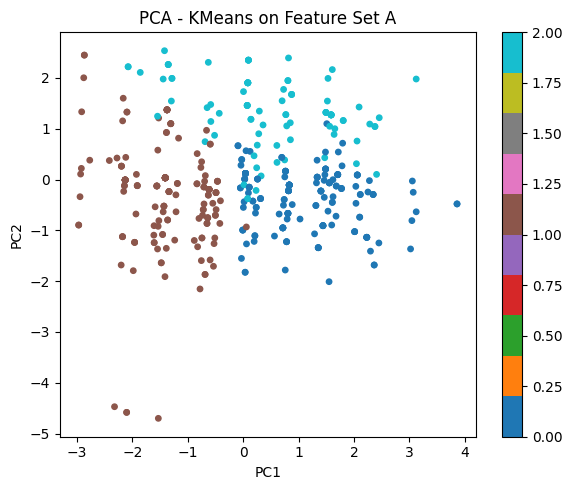

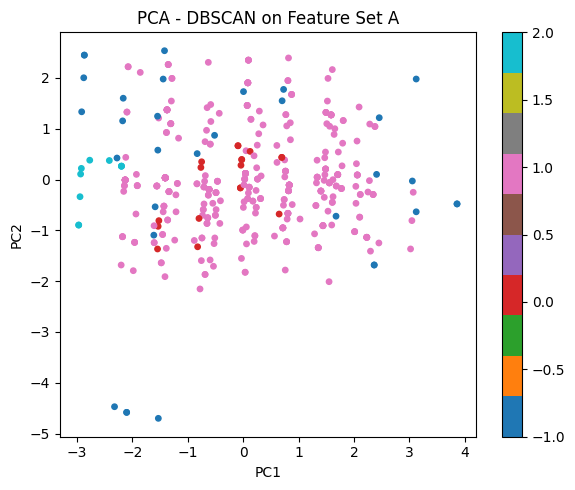

In [94]:
plot_pca(X_A_scaled, labels_kmeans_A, "KMeans on Feature Set A")
plot_pca(X_A_scaled, labels_dbscan_A, "DBSCAN on Feature Set A")

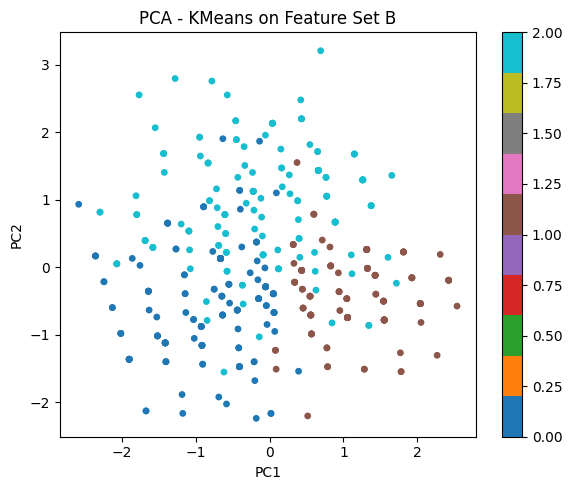

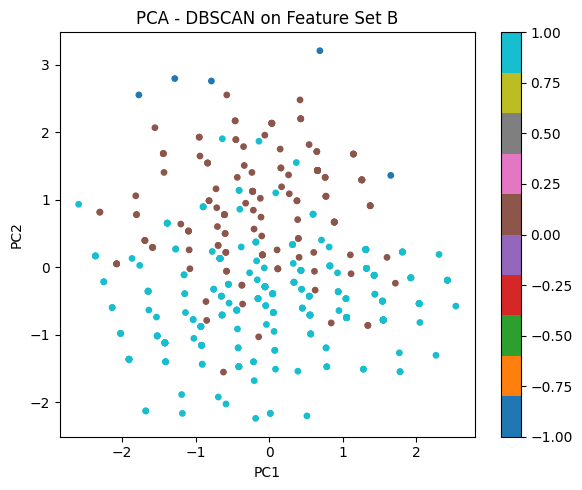

In [95]:
plot_pca(X_B_scaled, labels_kmeans_B, "KMeans on Feature Set B")
plot_pca(X_B_scaled, labels_dbscan_B, "DBSCAN on Feature Set B")

# Hyperparameter tuning for KMeans

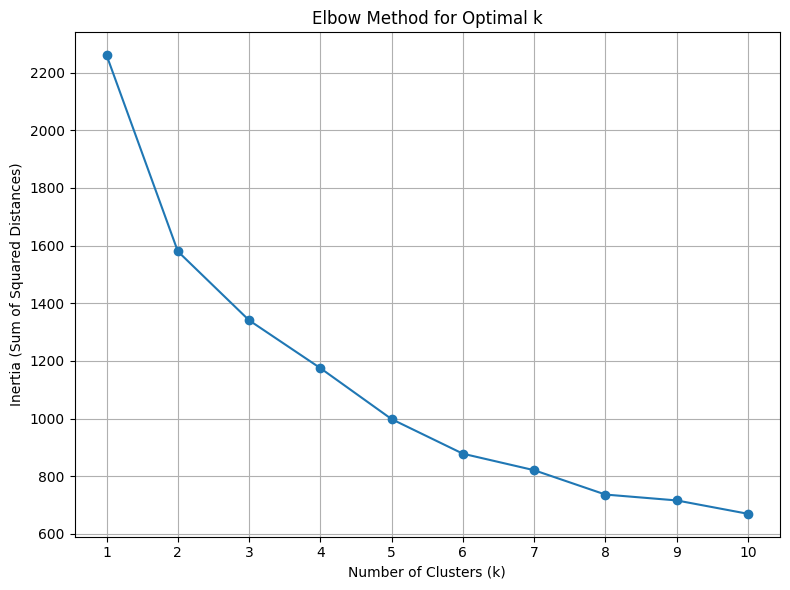

In [99]:
# Calculate inertia for a range of k values (1 to 10, for example)
ks = range(1, 11)
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_A_scaled)
    inertias.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(ks, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(ks)
plt.grid(True)
plt.tight_layout()
plt.show()

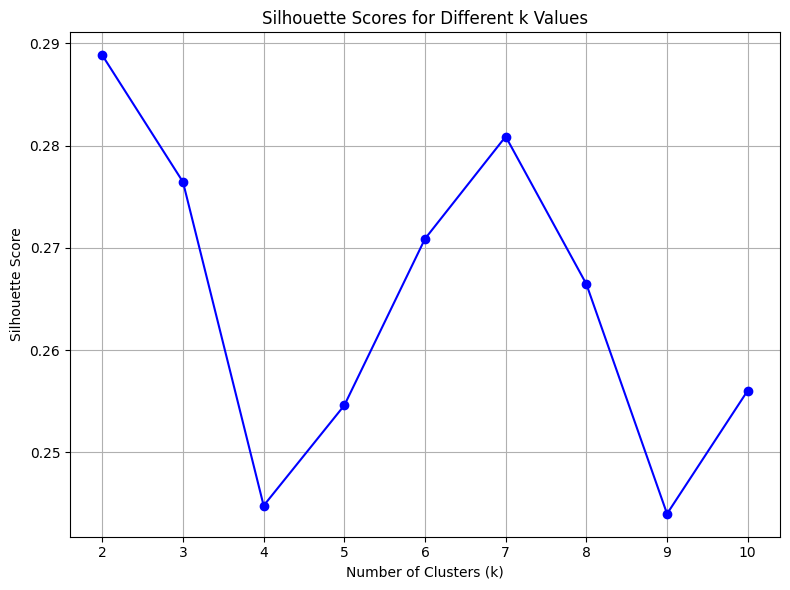

In [101]:
silhouette_scores = []

for k in ks[1:]:  # start from 2 since silhouette score isn't defined for 1 cluster
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X_A_scaled)
    score = silhouette_score(X_A_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(ks[1:], silhouette_scores, marker='o', color='b')
plt.title('Silhouette Scores for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()


In [103]:
# Tuned KMeans on A
kmeans_A = KMeans(n_clusters=7, init='k-means++', random_state=42)
labels_kmeans_A = kmeans_A.fit_predict(X_A_scaled)

# Tuned KMeans on B
kmeans_B = KMeans(n_clusters=7, init='k-means++', random_state=42)
labels_kmeans_B = kmeans_B.fit_predict(X_B_scaled)

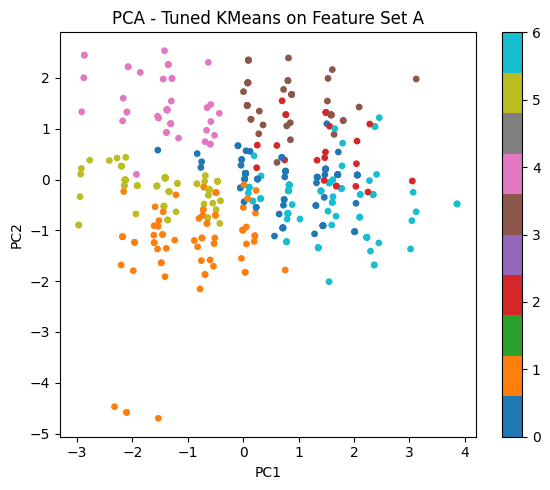

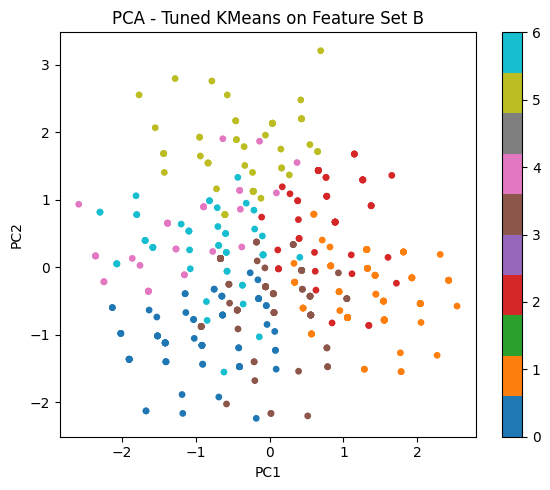

In [104]:
plot_pca(X_A_scaled, labels_kmeans_A, "Tuned KMeans on Feature Set A")
plot_pca(X_B_scaled, labels_kmeans_B, "Tuned KMeans on Feature Set B")

# Evaluation

Silhouette Score for KMeans on Feature Set A: 0.2808869887095792


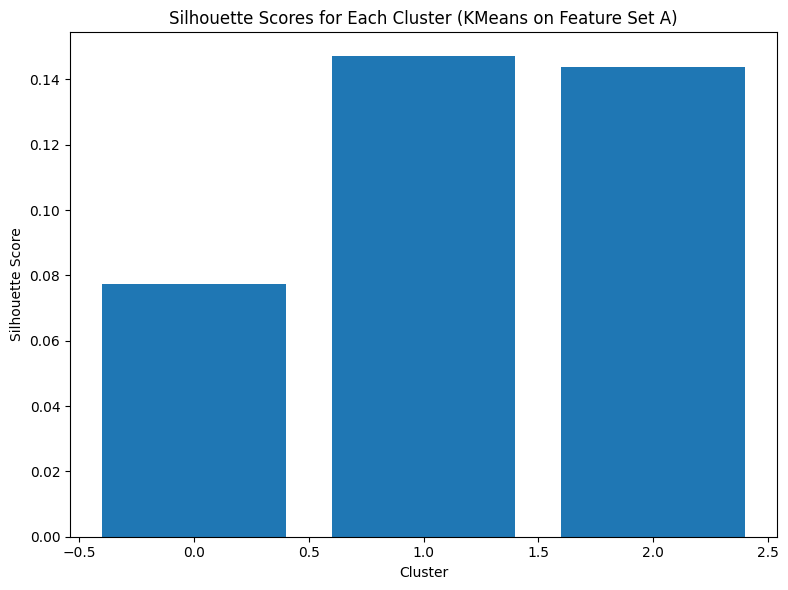

In [105]:
# Calculate silhouette score for KMeans on Feature Set A
sil_score_kmeans_A = silhouette_score(X_A_scaled, labels_kmeans_A)
print(f"Silhouette Score for KMeans on Feature Set A: {sil_score_kmeans_A}")

# Silhouette Score Plot
plt.figure(figsize=(8, 6))
plt.bar(range(3), [silhouette_score(X_A_scaled, labels_kmeans_A == i) for i in range(3)])
plt.title('Silhouette Scores for Each Cluster (KMeans on Feature Set A)')
plt.xlabel('Cluster')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

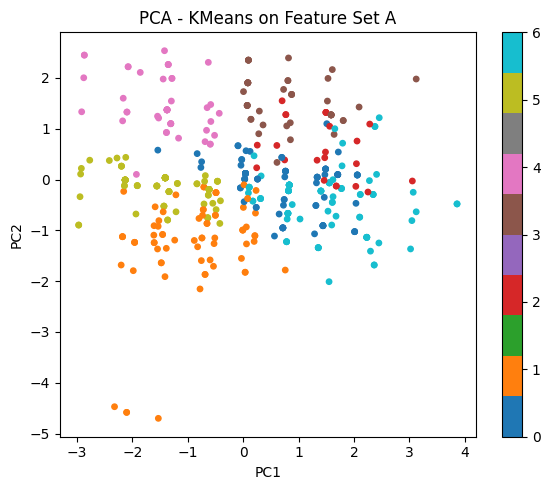

In [106]:
# Plotting clusters after KMeans on Feature Set A
plot_pca(X_A_scaled, labels_kmeans_A, 'KMeans on Feature Set A')

In [107]:
# Cluster Sizes (Number of points in each cluster)
cluster_sizes_A = np.bincount(labels_kmeans_A)
print("Cluster Sizes for KMeans on Feature Set A:", cluster_sizes_A)

# Centroids (Average position of each cluster)
centroids_A = kmeans_A.cluster_centers_
print(f"Centroids for KMeans on Feature Set A:\n{centroids_A}")

Cluster Sizes for KMeans on Feature Set A: [82 73 23 45 46 92 91]
Centroids for KMeans on Feature Set A:
[[-0.61545827  0.99961195  0.59826936 -0.19726989 -0.6013328 ]
 [-0.22940111 -0.55900492 -0.61780089  1.50183698 -0.34957726]
 [-0.11106221  1.24893104  1.02592512  0.85461849  1.48371966]
 [ 0.03961348  0.61043457  0.5270654  -0.69354544  1.49093377]
 [-0.39985728 -1.01387238 -1.03297818 -0.56716471  1.524299  ]
 [-0.26801605 -1.0599178  -1.01637412 -0.51248074 -0.64669588]
 [ 1.22018237  0.51422832  0.98627001 -0.09524005 -0.40671291]]
